In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
walden_snapshot = 'subugoe-collaborative.openalex_walden.works'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
def calculate_changes(df1_openalex, df2_walden, on):
    changes = pd.merge(df1_openalex, df2_walden, on=on, how='outer', suffixes=('_openalex', '_walden'))

    changes['n_openalex'] = changes['n_openalex'].fillna(0)
    changes['n_walden'] = changes['n_walden'].fillna(0)
    changes = changes[[on, 'n_openalex', 'n_walden']]

    changes['change'] = changes['n_walden'] - changes['n_openalex']
    changes['pct_change'] = (changes['n_walden'] - changes['n_openalex']) / changes['n_openalex'] * 100
    changes['pct_change'] = changes['pct_change'].apply(lambda x: '{:,.2f}'.format(x))

    return changes

In [6]:
oal_by_types = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, type
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY type
                             ORDER BY n DESC
                             """).to_dataframe()

In [7]:
oal_by_types

,n,type
0,15610743,article
1,693450,review
2,427285,paratext
3,158396,letter
4,113624,editorial
5,72718,erratum
6,55909,dataset
7,47159,book-chapter
8,36094,reference-entry
9,21027,other


In [8]:
walden_by_types = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, type
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                                GROUP BY type
                                ORDER BY n DESC
                                """).to_dataframe()

In [9]:
walden_by_types

,n,type
0,15804019,article
1,688378,review
2,436417,paratext
3,156103,letter
4,112829,editorial
5,103938,book-chapter
6,72181,erratum
7,32937,reference-entry
8,23960,preprint
9,20533,other


In [10]:
calculate_changes(oal_by_types, walden_by_types, on='type')

,type,n_openalex,n_walden,change,pct_change
0,article,15610743,15804019,193276,1.24
1,review,693450,688378,-5072,-0.73
2,paratext,427285,436417,9132,2.14
3,letter,158396,156103,-2293,-1.45
4,editorial,113624,112829,-795,-0.70
5,erratum,72718,72181,-537,-0.74
6,dataset,55909,1409,-54500,-97.48
7,book-chapter,47159,103938,56779,120.40
8,reference-entry,36094,32937,-3157,-8.75
9,other,21027,20533,-494,-2.35


In [11]:
print(calculate_changes(oal_by_types, walden_by_types, on='type').to_markdown())

|    | type                    |   n_openalex |   n_walden |   change | pct_change   |
|---:|:------------------------|-------------:|-----------:|---------:|:-------------|
|  0 | article                 |     15610743 |   15804019 |   193276 | 1.24         |
|  1 | review                  |       693450 |     688378 |    -5072 | -0.73        |
|  2 | paratext                |       427285 |     436417 |     9132 | 2.14         |
|  3 | letter                  |       158396 |     156103 |    -2293 | -1.45        |
|  4 | editorial               |       113624 |     112829 |     -795 | -0.70        |
|  5 | erratum                 |        72718 |      72181 |     -537 | -0.74        |
|  6 | dataset                 |        55909 |       1409 |   -54500 | -97.48       |
|  7 | book-chapter            |        47159 |     103938 |    56779 | 120.40       |
|  8 | reference-entry         |        36094 |      32937 |    -3157 | -8.75        |
|  9 | other                   |        210

In [12]:
oal_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM `subugoe-collaborative.openalex.works`
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [13]:
oal_by_source_types

,n,source_type
0,17281019,journal
1,3677588,None
2,3593723,repository
3,2732665,ebook platform
4,664146,book series
5,568721,conference
6,11,other


In [14]:
walden_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM {walden_snapshot}
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [15]:
walden_by_source_types

,n,source_type
0,28534221,repository
1,17486708,journal
2,6377383,None
3,5370220,igsnCatalog
4,1769759,ebook platform
5,661006,book series
6,301899,conference
7,135,metadata
8,53,other
9,4,raidRegistry


In [16]:
calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type')

,source_type,n_openalex,n_walden,change,pct_change
0,journal,17281019,17486708,205689,1.19
1,None,3677588,6377383,2699795,73.41
2,repository,3593723,28534221,24940498,694.00
3,ebook platform,2732665,1769759,-962906,-35.24
4,book series,664146,661006,-3140,-0.47
5,conference,568721,301899,-266822,-46.92
6,other,11,53,42,381.82
7,igsnCatalog,0,5370220,5370220,inf
8,metadata,0,135,135,inf
9,raidRegistry,0,4,4,inf


In [17]:
print(calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type').to_markdown())

|    | source_type    |   n_openalex |   n_walden |   change |   pct_change |
|---:|:---------------|-------------:|-----------:|---------:|-------------:|
|  0 | journal        |     17281019 |   17486708 |   205689 |         1.19 |
|  1 |                |      3677588 |    6377383 |  2699795 |        73.41 |
|  2 | repository     |      3593723 |   28534221 | 24940498 |       694    |
|  3 | ebook platform |      2732665 |    1769759 |  -962906 |       -35.24 |
|  4 | book series    |       664146 |     661006 |    -3140 |        -0.47 |
|  5 | conference     |       568721 |     301899 |  -266822 |       -46.92 |
|  6 | other          |           11 |         53 |       42 |       381.82 |
|  7 | igsnCatalog    |            0 |    5370220 |  5370220 |       inf    |
|  8 | metadata       |            0 |        135 |      135 |       inf    |
|  9 | raidRegistry   |            0 |          4 |        4 |       inf    |


In [18]:
oal_by_oa = client.query(f"""
                          SELECT COUNT(DISTINCT(doi)) AS n, open_access.is_oa, open_access.oa_status
                          FROM {openalex_snapshot}
                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                          GROUP BY is_oa, oa_status
                          ORDER BY n DESC
                          """).to_dataframe()

In [19]:
oal_by_oa

,n,is_oa,oa_status
0,6639794,False,closed
1,4419565,True,gold
2,2097302,True,hybrid
3,1469074,True,bronze
4,1178478,True,diamond
5,499993,True,green


In [20]:
walden_by_oa = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, open_access.is_oa, open_access.oa_status
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY is_oa, oa_status
                             ORDER BY n DESC
                             """).to_dataframe()

In [21]:
walden_by_oa

,n,is_oa,oa_status
0,5543476,False,closed
1,4415079,True,diamond
2,2885171,True,gold
3,1857336,True,hybrid
4,1304379,True,bronze
5,487170,True,green
6,15,True,closed


In [22]:
calculate_changes(oal_by_oa, walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status')

,oa_status,n_openalex,n_walden,change,pct_change
0,closed,6639794,5543491,-1096303,-16.51
1,gold,4419565,2885171,-1534394,-34.72
2,hybrid,2097302,1857336,-239966,-11.44
3,bronze,1469074,1304379,-164695,-11.21
4,diamond,1178478,4415079,3236601,274.64
5,green,499993,487170,-12823,-2.56


In [23]:
print(calculate_changes(oal_by_oa, walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status').to_markdown())

|    | oa_status   |   n_openalex |   n_walden |   change |   pct_change |
|---:|:------------|-------------:|-----------:|---------:|-------------:|
|  0 | closed      |      6639794 |    5543491 | -1096303 |       -16.51 |
|  1 | gold        |      4419565 |    2885171 | -1534394 |       -34.72 |
|  2 | hybrid      |      2097302 |    1857336 |  -239966 |       -11.44 |
|  3 | bronze      |      1469074 |    1304379 |  -164695 |       -11.21 |
|  4 | diamond     |      1178478 |    4415079 |  3236601 |       274.64 |
|  5 | green       |       499993 |     487170 |   -12823 |        -2.56 |


In [24]:
oal_by_host = client.query(f"""
                            SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                            FROM {openalex_snapshot}
                            WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                            GROUP BY host_organization_name
                            ORDER BY n DESC
                            """).to_dataframe()

In [25]:
oal_by_host

,n,host_organization_name
0,4406230,None
1,2488907,Elsevier BV
2,808028,Multidisciplinary Digital Publishing Institute
3,786127,Springer Science+Business Media
4,736327,Wiley
...,...,...
6322,0,Middle East Forum
6323,0,Khon Kaen University
6324,0,Michael J. Thompson
6325,0,"World Academy of Science, Engineering and Tech..."


In [26]:
walden_by_host = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY host_organization_name
                             ORDER BY n DESC
                             """).to_dataframe()

In [27]:
walden_by_host

,n,host_organization_name
0,4594482,None
1,2486835,Elsevier BV
2,806939,Multidisciplinary Digital Publishing Institute
3,792846,Springer Science+Business Media
4,733615,Wiley
...,...,...
6395,0,Technical University of Munich
6396,0,Touro College
6397,0,Council on Foreign Relations
6398,0,University of Illinois College of Law


In [28]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,None,4406230,4594482,188252,4.27
1,Elsevier BV,2488907,2486835,-2072,-0.08
2,Multidisciplinary Digital Publishing Institute,808028,806939,-1089,-0.13
3,Springer Science+Business Media,786127,792846,6719,0.85
4,Wiley,736327,733615,-2712,-0.37
5,Taylor & Francis,367153,367567,414,0.11
6,Frontiers Media,267408,267480,72,0.03
7,Oxford University Press,252446,252498,52,0.02
8,SAGE Publishing,228762,228486,-276,-0.12
9,Institute of Electrical and Electronics Engineers,219312,218624,-688,-0.31


In [29]:
print(calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

|    | host_organization_name                            |   n_openalex |   n_walden |   change |   pct_change |
|---:|:--------------------------------------------------|-------------:|-----------:|---------:|-------------:|
|  0 |                                                   |      4406230 |    4594482 |   188252 |         4.27 |
|  1 | Elsevier BV                                       |      2488907 |    2486835 |    -2072 |        -0.08 |
|  2 | Multidisciplinary Digital Publishing Institute    |       808028 |     806939 |    -1089 |        -0.13 |
|  3 | Springer Science+Business Media                   |       786127 |     792846 |     6719 |         0.85 |
|  4 | Wiley                                             |       736327 |     733615 |    -2712 |        -0.37 |
|  5 | Taylor & Francis                                  |       367153 |     367567 |      414 |         0.11 |
|  6 | Frontiers Media                                   |       267408 |     267480 |       72 

In [30]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['change'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,None,4406230,4594482,188252,4.27
3,Springer Science+Business Media,786127,792846,6719,0.85
29,Thieme Medical Publishers (Germany),54470,57153,2683,4.93
18,Cambridge University Press,96301,97781,1480,1.54
1073,Q1285359,593,2063,1470,247.89
30,BMJ,52822,53896,1074,2.03
10,Lippincott Williams & Wilkins,214001,215062,1061,0.50
267,Peoples' Friendship University of Russia,2718,3778,1060,39.00
56,Science Press,16456,17301,845,5.13
14,Springer Nature,137535,138302,767,0.56


In [31]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['change'], ascending=False).tail(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
149,Akadémiai Kiadó,4960,4341,-619,-12.48
92,JMIR Publications,9308,8663,-645,-6.93
69,African Journals OnLine,13173,12523,-650,-4.93
984,American Astronomical Society,673,0,-673,-100.00
9,Institute of Electrical and Electronics Engineers,219312,218624,-688,-0.31
232,InScience LLC,3228,2531,-697,-21.59
17,IOP Publishing,107898,107132,-766,-0.71
711,AI Publications,994,199,-795,-79.98
702,IJEAST,1003,191,-812,-80.96
40,De Gruyter Open,25786,24835,-951,-3.69


In [32]:
oal_by_host_references = client.query(f"""
                                      SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                      FROM {openalex_snapshot}
                                      WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                      GROUP BY host_organization_name
                                      ORDER BY n DESC
                                      """).to_dataframe()

In [33]:
oal_by_host_references

,n,host_organization_name
0,99552763,Elsevier BV
1,42306176,Multidisciplinary Digital Publishing Institute
2,33877276,None
3,31926819,Springer Science+Business Media
4,31252965,Wiley
...,...,...
6322,0,College of Veterinary Medicine
6323,0,Thomson Reuters (Professional) Australia Limited
6324,0,"The Medical Letter, Inc."
6325,0,Nigeria Maritime University


In [34]:
walden_by_host_references = client.query(f"""
                                          SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                          FROM {walden_snapshot}
                                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                          GROUP BY host_organization_name
                                          ORDER BY n DESC
                                          """).to_dataframe()

In [35]:
walden_by_host_references

,n,host_organization_name
0,109168209,Elsevier BV
1,45172150,Multidisciplinary Digital Publishing Institute
2,38658424,None
3,33223165,Springer Science+Business Media
4,32518444,Wiley
...,...,...
6395,0,Centro Latinoamericano de Estudos em Cultura
6396,0,Catholic University of El Salvador
6397,0,Instituto de Estudios Madrileños
6398,0,Beletrina Academic Press


In [36]:
print(calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

|    | host_organization_name                            |   n_openalex |   n_walden |   change |   pct_change |
|---:|:--------------------------------------------------|-------------:|-----------:|---------:|-------------:|
|  0 | Elsevier BV                                       |     99552763 |  109168209 |  9615446 |         9.66 |
|  1 | Multidisciplinary Digital Publishing Institute    |     42306176 |   45172150 |  2865974 |         6.77 |
|  2 |                                                   |     33877276 |   38658424 |  4781148 |        14.11 |
|  3 | Springer Science+Business Media                   |     31926819 |   33223165 |  1296346 |         4.06 |
|  4 | Wiley                                             |     31252965 |   32518444 |  1265479 |         4.05 |
|  5 | Frontiers Media                                   |     15792532 |   16325270 |   532738 |         3.37 |
|  6 | Taylor & Francis                                  |     13892854 |   14536016 |   643162 

In [37]:
calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['change'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,Elsevier BV,99552763,109168209,9615446,9.66
2,None,33877276,38658424,4781148,14.11
1,Multidisciplinary Digital Publishing Institute,42306176,45172150,2865974,6.77
12,Institute of Electrical and Electronics Engineers,6484987,8255490,1770503,27.30
3,Springer Science+Business Media,31926819,33223165,1296346,4.06
4,Wiley,31252965,32518444,1265479,4.05
11,Oxford University Press,6495768,7192185,696417,10.72
6,Taylor & Francis,13892854,14536016,643162,4.63
5,Frontiers Media,15792532,16325270,532738,3.37
16,IOP Publishing,3583768,4107631,523863,14.62


In [38]:
calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['change'], ascending=False).tail(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
2387,NeuroQuantology,2424,151,-2273,-93.77
887,Frontline Medical Communications,9361,6959,-2402,-25.66
2329,Zoological Survey of India,2500,0,-2500,-100.00
2304,Pesticide Science Society of Japan,2539,0,-2539,-100.00
2201,Society of Physicians and Naturalists,2753,0,-2753,-100.00
1424,Association of Basic Medical Sciences of Feder...,5195,2425,-2770,-53.32
2011,Allergy and Immunology Society of Thailand,3242,0,-3242,-100.00
2005,Korean Academy of Nursing Administration,3261,0,-3261,-100.00
1387,AI Publications,5367,1440,-3927,-73.17
1385,Sociedad Argentina de Cardiología,5373,863,-4510,-83.94


In [39]:
oal_by_pubyear = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                               FROM `subugoe-collaborative.openalex.works`
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2020 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY publication_year
                               ORDER BY publication_year DESC
                               """).to_dataframe()

In [40]:
oal_by_pubyear

,n,publication_year
0,5747463,2024
1,5385802,2023
2,5170934,2022
3,5168607,2021
4,4865503,2020


In [41]:
walden_by_pubyear = client.query(f"""
                                  SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                                  FROM {walden_snapshot}
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2020 AND 2024 AND (type = 'article' OR type = 'review')
                                  GROUP BY publication_year
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [42]:
walden_by_pubyear

,n,publication_year
0,5866769,2024
1,5421376,2023
2,5204308,2022
3,5113724,2021
4,4820914,2020


In [43]:
calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False)

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,5747463,5866769,119306,2.08
1,2023,5385802,5421376,35574,0.66
2,2022,5170934,5204308,33374,0.65
4,2020,4865503,4820914,-44589,-0.92
3,2021,5168607,5113724,-54883,-1.06


In [44]:
print(calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False).to_markdown())

|    |   publication_year |   n_openalex |   n_walden |   change |   pct_change |
|---:|-------------------:|-------------:|-----------:|---------:|-------------:|
|  0 |               2024 |      5747463 |    5866769 |   119306 |         2.08 |
|  1 |               2023 |      5385802 |    5421376 |    35574 |         0.66 |
|  2 |               2022 |      5170934 |    5204308 |    33374 |         0.65 |
|  4 |               2020 |      4865503 |    4820914 |   -44589 |        -0.92 |
|  3 |               2021 |      5168607 |    5113724 |   -54883 |        -1.06 |


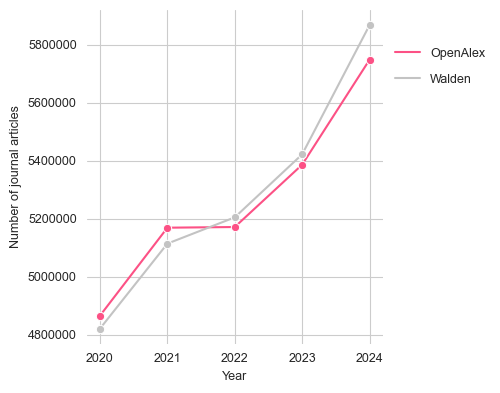

In [45]:
fig, ax = plt.subplots(figsize=(4,4))
plt.box(False)

sns.lineplot(data=oal_by_pubyear,
             x='publication_year',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=walden_by_pubyear,
             x='publication_year',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Year', ylabel='Number of journal articles')
ax.set_xticks(range(2020,2025))

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex')
walden_patch = Line2D([0], [0], color='#c3c3c3', label='Walden')

lgd = fig.legend(handles=[oal_patch, walden_patch], frameon=False,
                 bbox_to_anchor=(1.25, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oal_walden_comparison_article_pubyear.png', format='png', bbox_inches='tight', dpi=500)

In [46]:
oal_by_index = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY indexed_in
                             ORDER BY n DESC
                             """).to_dataframe()

In [47]:
oal_by_index

,n,indexed_in
0,11726898,[crossref]
1,3678404,"[crossref, pubmed]"
2,434098,"[crossref, doaj, pubmed]"
3,354468,"[crossref, doaj]"
4,45187,"[arxiv, crossref]"
5,40214,"[arxiv, crossref, datacite]"
6,8175,"[arxiv, crossref, pubmed]"
7,7136,"[arxiv, crossref, datacite, pubmed]"
8,4324,"[arxiv, crossref, datacite, doaj]"
9,1829,"[arxiv, crossref, doaj]"


In [48]:
oal_by_index_explode = oal_by_index.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [49]:
oal_by_index_explode

,indexed_in,n
1,crossref,16303367
4,pubmed,4129715
3,doaj,796361
0,arxiv,108489
2,datacite,53760


In [50]:
walden_by_index = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                GROUP BY indexed_in
                                ORDER BY n DESC
                                """).to_dataframe()

In [51]:
walden_by_index

,n,indexed_in
0,9793215,[crossref]
1,2526406,"[crossref, doaj]"
2,2294263,"[crossref, pubmed]"
3,1679373,"[crossref, doaj, pubmed]"
4,49510,[datacite]
5,33642,"[arxiv, crossref]"
6,27159,"[crossref, datacite]"
7,22983,"[crossref, datacite, pubmed]"
8,18845,"[crossref, datacite, doaj, pubmed]"
9,17303,"[arxiv, crossref, doaj]"


In [52]:
walden_by_index_explode = walden_by_index.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [53]:
walden_by_index_explode

,indexed_in,n
1,crossref,16439256
3,doaj,4259521
4,pubmed,4024872
2,datacite,138476
0,arxiv,66351


In [54]:
calculate_changes(oal_by_index_explode, walden_by_index_explode, on='indexed_in').sort_values(by=['change'], ascending=False)

,indexed_in,n_openalex,n_walden,change,pct_change
2,doaj,796361,4259521,3463160,434.87
0,crossref,16303367,16439256,135889,0.83
4,datacite,53760,138476,84716,157.58
3,arxiv,108489,66351,-42138,-38.84
1,pubmed,4129715,4024872,-104843,-2.54


In [55]:
print(calculate_changes(oal_by_index_explode, walden_by_index_explode, on='indexed_in').sort_values(by=['change'], ascending=False).to_markdown())

|    | indexed_in   |   n_openalex |   n_walden |   change |   pct_change |
|---:|:-------------|-------------:|-----------:|---------:|-------------:|
|  2 | doaj         |       796361 |    4259521 |  3463160 |       434.87 |
|  0 | crossref     |     16303367 |   16439256 |   135889 |         0.83 |
|  4 | datacite     |        53760 |     138476 |    84716 |       157.58 |
|  3 | arxiv        |       108489 |      66351 |   -42138 |       -38.84 |
|  1 | pubmed       |      4129715 |    4024872 |  -104843 |        -2.54 |


In [56]:
oal_by_index_all = client.query(f"""
                                 SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                 FROM `subugoe-collaborative.openalex.works`
                                 WHERE publication_year BETWEEN 2022 AND 2024
                                 GROUP BY indexed_in
                                 ORDER BY n DESC
                                 """).to_dataframe()

In [57]:
oal_by_index_all

,n,indexed_in
0,21173046,[crossref]
1,4043482,"[crossref, pubmed]"
2,1194723,[datacite]
3,557047,[]
4,451148,"[crossref, doaj, pubmed]"
5,359105,"[crossref, doaj]"
6,323673,"[arxiv, datacite]"
7,213369,[arxiv]
8,56908,[pubmed]
9,51195,"[arxiv, crossref]"


In [58]:
oal_by_index_all_explode = oal_by_index_all.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [59]:
oal_by_index_all_explode

,indexed_in,n
1,crossref,26149607
4,pubmed,4572091
2,datacite,1580251
3,doaj,840008
0,arxiv,659630


In [60]:
walden_by_index_all = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                FROM {walden_snapshot}
                                WHERE publication_year BETWEEN 2022 AND 2024
                                GROUP BY indexed_in
                                ORDER BY n DESC
                                """).to_dataframe()

In [61]:
walden_by_index_all

,n,indexed_in
0,31197790,[datacite]
1,19143911,[crossref]
2,2642333,"[crossref, doaj]"
3,2574504,"[crossref, pubmed]"
4,2186593,[]
5,1767831,"[crossref, doaj, pubmed]"
6,567660,"[arxiv, datacite]"
7,129965,[doaj]
8,53965,[pubmed]
9,47928,"[arxiv, crossref]"


In [62]:
walden_by_index_all_explode = walden_by_index_all.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [63]:
walden_by_index_all_explode

,indexed_in,n
2,datacite,31919449
1,crossref,26315869
3,doaj,4639906
4,pubmed,4459692
0,arxiv,663984


In [64]:
calculate_changes(oal_by_index_all_explode, walden_by_index_all_explode, on='indexed_in').sort_values(by=['change'], ascending=False)

,indexed_in,n_openalex,n_walden,change,pct_change
2,datacite,1580251,31919449,30339198,"1,919.90"
3,doaj,840008,4639906,3799898,452.36
0,crossref,26149607,26315869,166262,0.64
4,arxiv,659630,663984,4354,0.66
1,pubmed,4572091,4459692,-112399,-2.46


In [65]:
print(calculate_changes(oal_by_index_all_explode, walden_by_index_all_explode, on='indexed_in').sort_values(by=['change'], ascending=False).to_markdown())

|    | indexed_in   |   n_openalex |   n_walden |   change | pct_change   |
|---:|:-------------|-------------:|-----------:|---------:|:-------------|
|  2 | datacite     |      1580251 |   31919449 | 30339198 | 1,919.90     |
|  3 | doaj         |       840008 |    4639906 |  3799898 | 452.36       |
|  0 | crossref     |     26149607 |   26315869 |   166262 | 0.64         |
|  4 | arxiv        |       659630 |     663984 |     4354 | 0.66         |
|  1 | pubmed       |      4572091 |    4459692 |  -112399 | -2.46        |


In [66]:
oal_grants = client.query(f"""
                           SELECT COUNT(grant.award_id) AS n, grant.funder_display_name
                           FROM `subugoe-collaborative.openalex.works`, UNNEST(grants) AS grant
                           WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                           GROUP BY funder_display_name
                           ORDER BY n DESC
                           """).to_dataframe()

In [67]:
oal_grants

,n,funder_display_name
0,1463516,National Natural Science Foundation of China
1,163991,National Key Research and Development Program ...
2,128342,Japan Society for the Promotion of Science
3,126402,National Institutes of Health
4,118946,National Science Foundation
...,...,...
27642,0,Tzu Chi College of Technology
27643,0,International Society for Music Education
27644,0,General Sekiyu Research and Development Encour...
27645,0,Korea Institute of Child Care and Education


In [68]:
oal_grants.n.sum()

5420652

In [69]:
walden_grants = client.query(f"""
                               SELECT COUNT(grant.id) AS n, grant.funder_display_name
                               FROM {walden_snapshot}, UNNEST(awards) AS grant
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY funder_display_name
                               ORDER BY n DESC
                               """).to_dataframe()

In [70]:
walden_grants

,n,funder_display_name
0,1457223,National Natural Science Foundation of China
1,163096,National Key Research and Development Program ...
2,126596,Japan Society for the Promotion of Science
3,125356,National Institutes of Health
4,116257,National Science Foundation
...,...,...
21534,1,Ting Tsung and Wei Fong Chao Family Foundation
21535,1,International Association for Identification
21536,1,"Chengdu Institute of Plateau Meteorology, Chin..."
21537,1,Healthcare Georgia Foundation


In [71]:
walden_grants.n.sum()

5574901

In [72]:
calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['n_openalex'], ascending=False).head(20)

,funder_display_name,n_openalex,n_walden,change,pct_change
0,National Natural Science Foundation of China,1463516,1457223,-6293,-0.43
1,National Key Research and Development Program ...,163991,163096,-895,-0.55
2,Japan Society for the Promotion of Science,128342,126596,-1746,-1.36
3,National Institutes of Health,126402,125356,-1046,-0.83
4,National Science Foundation,118946,116257,-2689,-2.26
5,Fundamental Research Funds for the Central Uni...,87326,86786,-540,-0.62
6,Deutsche Forschungsgemeinschaft,86309,84276,-2033,-2.36
7,National Research Foundation of Korea,75647,75220,-427,-0.56
8,China Postdoctoral Science Foundation,60066,59810,-256,-0.43
9,Conselho Nacional de Desenvolvimento Científic...,43147,42752,-395,-0.92


In [73]:
calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['change'], ascending=False).head(20)

,funder_display_name,n_openalex,n_walden,change,pct_change
13,Engineering and Physical Sciences Research Cou...,33358,87044,53686,160.94
97,Science and Technology Facilities Council,7645,47278,39633,518.42
73,Medical Research Council,9486,49104,39618,417.65
84,Biotechnology and Biological Sciences Research...,8669,28695,20026,231.01
6695,Sight Research UK,20,18956,18936,"94,680.00"
108,Natural Environment Research Council,6681,25589,18908,283.01
147,Economic and Social Research Council,4398,13665,9267,210.71
420,Arts and Humanities Research Council,1023,3128,2105,205.77
1708,Shota Rustaveli National Science Foundation,177,187,10,5.65
914,Lembaga Pengelola Dana Pendidikan,379,382,3,0.79


In [74]:
calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['change'], ascending=False).tail(20)

,funder_display_name,n_openalex,n_walden,change,pct_change
11,Fundação para a Ciência e a Tecnologia,33985,33659,-326,-0.96
14,Australian Research Council,28688,28317,-371,-1.29
9,Conselho Nacional de Desenvolvimento Científic...,43147,42752,-395,-0.92
27,Schweizerischer Nationalfonds zur Förderung de...,20699,20288,-411,-1.99
7,National Research Foundation of Korea,75647,75220,-427,-0.56
43,Horizon 2020 Framework Programme,15494,15061,-433,-2.79
18,Natural Sciences and Engineering Research Coun...,25888,25454,-434,-1.68
50,European Research Council,13427,12921,-506,-3.77
34,H2020 European Research Council,19039,18513,-526,-2.76
5,Fundamental Research Funds for the Central Uni...,87326,86786,-540,-0.62


In [75]:
print(calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

|    | funder_display_name                                               |   n_openalex |   n_walden |   change |   pct_change |
|---:|:------------------------------------------------------------------|-------------:|-----------:|---------:|-------------:|
|  0 | National Natural Science Foundation of China                      |      1463516 |    1457223 |    -6293 |        -0.43 |
|  1 | National Key Research and Development Program of China            |       163991 |     163096 |     -895 |        -0.55 |
|  2 | Japan Society for the Promotion of Science                        |       128342 |     126596 |    -1746 |        -1.36 |
|  3 | National Institutes of Health                                     |       126402 |     125356 |    -1046 |        -0.83 |
|  4 | National Science Foundation                                       |       118946 |     116257 |    -2689 |        -2.26 |
|  5 | Fundamental Research Funds for the Central Universities           |        87326 |      86